# Reading and Analyzing the Data

In [1]:
import pandas as pd
import os

In [2]:
df = pd.read_csv(os.path.join('/home/muhammadfaizan/Faizan/AXIOM/working with LSTM/ge-stock/','ge.us.txt'),engine='python')

In [3]:
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
...,...,...,...,...,...,...,...
14053,2017-11-06,20.5200,20.5300,20.0800,20.1300,60641787,0
14054,2017-11-07,20.1700,20.2500,20.1200,20.2100,41622851,0
14055,2017-11-08,20.2100,20.3200,20.0700,20.1200,39672190,0
14056,2017-11-09,20.0400,20.0710,19.8500,19.9900,50831779,0


In [4]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'GE stock price history')

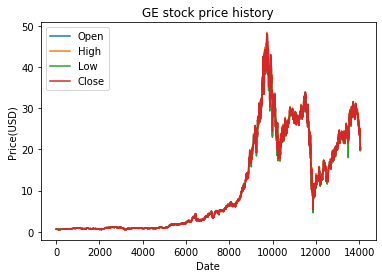

In [5]:
plt.plot(df['Open'])
plt.plot(df['High'])
plt.plot(df['Low'])
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend(['Open','High','Low','Close'],loc='upper left')
plt.title('GE stock price history')

Text(0.5, 1.0, 'GE Volume history')

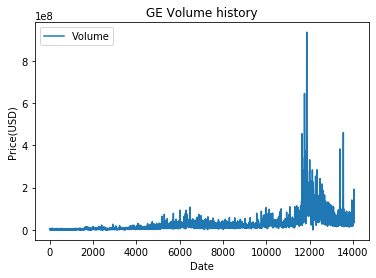

In [6]:
plt.plot(df['Volume'])
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend(['Volume'],loc='upper left')
plt.title('GE Volume history')

In [7]:
df.isna().sum() #checking for NaN values

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

# Normalizing the data

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
y = df_test.loc[:,train_cols]

min_max_scaler = MinMaxScaler()

x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(y)

Train and Test size 9840 4218


In [9]:
x_train

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02133307],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01381676],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01779596],
       ...,
       [0.78617939, 0.77771342, 0.76847953, 0.76843069, 0.24323557],
       [0.78190805, 0.77454623, 0.77388839, 0.77267465, 0.19995234],
       [0.77765786, 0.77669241, 0.77388839, 0.77267465, 0.18214718]])

In [10]:
x_test

array([[0.77987811, 0.7974875 , 0.77700644, 0.80023943, 0.24900289],
       [0.80540041, 0.79652901, 0.79626623, 0.79584839, 0.18125022],
       [0.80214404, 0.79231999, 0.78659392, 0.78433506, 0.14749712],
       ...,
       [0.4176391 , 0.41367433, 0.41613996, 0.41307201, 0.36521458],
       [0.41404441, 0.40848598, 0.41147349, 0.41034074, 0.46866274],
       [0.4127757 , 0.42117557, 0.41253405, 0.42084561, 0.93092153]])

In [18]:
import numpy as np
import tqdm

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm.tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [12]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [13]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [19]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

/home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



length of time-series i/o (9780, 60, 5) (9780,)



length of time-series i/o (4158, 60, 5) (4158,)


In [20]:
from keras import models
from keras import layers
from keras import optimizers

lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.Dense(20,activation='relu'))
lstm_model.add(layers.Dense(1,activation='sigmoid'))

optimizer = optimizers.RMSprop(lr=0.01)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

Using TensorFlow backend.
/home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/muhammadfaizan/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [21]:
from keras import callbacks

csv_logger = callbacks.CSVLogger(os.path.join('/home/muhammadfaizan/Faizan/AXIOM/working with LSTM', 
                                    'LSTM_Output' + '.log'),append=True)


history = lstm_model.fit(x_t, y_t, epochs=10, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 9780 samples, validate on 2060 samples
Epoch 1/10
 - 36s - loss: 0.0038 - val_loss: 0.0582
Epoch 2/10
 - 35s - loss: 0.0171 - val_loss: 0.1070
Epoch 3/10
 - 35s - loss: 0.0483 - val_loss: 0.2986
Epoch 4/10
 - 36s - loss: 0.0466 - val_loss: 0.2987
Epoch 5/10
 - 38s - loss: 0.0213 - val_loss: 0.2367
Epoch 6/10
 - 34s - loss: 0.0838 - val_loss: 0.2367
Epoch 7/10
 - 34s - loss: 0.1271 - val_loss: 0.2987
Epoch 8/10
 - 34s - loss: 0.0393 - val_loss: 0.2367
Epoch 9/10
 - 31s - loss: 0.0478 - val_loss: 0.2987
Epoch 10/10
 - 33s - loss: 0.0438 - val_loss: 0.2987
